<a href="https://colab.research.google.com/github/sbogde/scikit-regressions-and-confessions/blob/main/assess_dtr_kc_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [468]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [469]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [470]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [471]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/Colab Notebooks/kc_house_data.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './kc_house_data.csv'  # Local path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [472]:
data = pd.read_csv(file_path)

In [473]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [474]:
# Check and handle missing values:
data.isnull().sum()

,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
grade,0
sqft_above,0
sqft_basement,0
yr_built,0


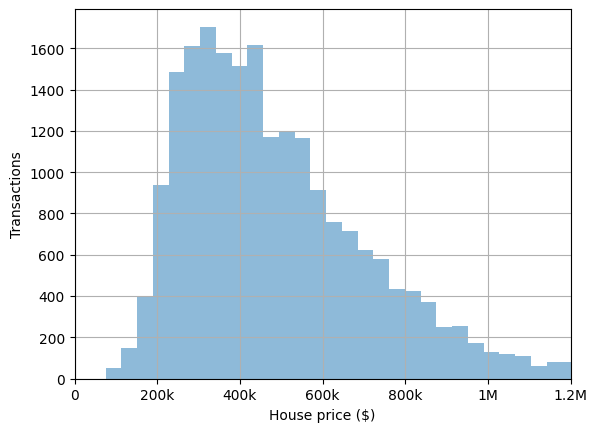

In [475]:
# Histogram of sale prices
plt.hist(data['price'], bins=200, alpha=0.5)
plt.grid()
plt.xlabel('House price ($)')
plt.ylabel('Transactions')
plt.xticks(ticks=[0, 200000, 400000, 600000, 800000, 1000000, 1200000],
           labels=['0', '200k', '400k', '600k', '800k', '1M', '1.2M'])

plt.xlim(0,1200000)
plt.show()

In [ ]:
# Define groups of columns based on their characteristics
columns_area = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement']
columns_year = ['yr_renovated', 'yr_built']
columns_room = ['bathrooms', 'bedrooms', 'floors']
columns_rate = ['grade', 'view', 'waterfront', 'condition']
titles_area = ['Living Area', 'Neighbours Living Area', 'Lot Area', 'Neighbours Lot Area', 'Above Area', 'Basement Area']
titles_year = ['Renovated Year', 'Built Year']
titles_rate = ['Grade Rate', 'View Rate', 'Waterfront Rate', 'Condition Rate']

# Colour palette for visualisation
my_colors = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

# Set the columns and titles for plotting (e.g., for area-related features)
columns = columns_area
titles = titles_area

# Calculate the number of columns and rows for the subplots
num_cols = len(columns)
num_rows = math.ceil(num_cols / 2)  # Arrange subplots in two rows for better readability

# Create a figure for the subplots
plt.figure(figsize=(18, 12), facecolor='#F2F2F2')  # Light grey background for better contrast

# Loop through each feature in the group and plot its distribution
for i, (column, title) in enumerate(zip(columns, titles), 1):
    plt.subplot(int(num_rows), 2, i)  # Create a subplot for each feature
    plt.title(f'{i}) {title}', color='#4A4A4A', fontsize=14)  # Add title with dark grey text
    sns.histplot(data[column], kde=True, color=my_colors[i % len(my_colors)], alpha=0.8)  # Add histogram with smooth curve

# Add a main title for the entire figure
plt.suptitle('Distribution Plots for Area-Related Features', color='#333333', size=20)

# Adjust layout to avoid overlapping of plots and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()

In [ ]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Compute the correlation of all features with the target variable 'price' and sort them in descending order
# This helps identify features that have the strongest positive or negative linear relationship with 'price'
# Features with higher correlation values are more likely to contribute significantly to the model
data.corr()['price'].sort_values(ascending=False)

In [ ]:
# Importing Plotly Express for creating interactive visualisations
import plotly.express as px

# Filter the dataset to include only properties with a high grade (grade >= 9)
high_grade_properties = data[data.grade >= 9]

fig = px.scatter_mapbox(
    data_frame=high_grade_properties,
    lat='lat',
    lon='long',
    zoom=10,
    height=500,
    hover_data={'price': True, 'grade': True, 'yr_built': True},
)

# Set the map style to "open-street-map" for a clean and familiar layout
fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# Drop irrelevant or weakly correlated features
# SVR old code (dropped lat and long as SVR doesn't benefit from spatial data patterns)
# X = data.drop(columns=['price', 'sqft_lot', 'sqft_lot15', 'lat', 'long'])

# Retain latitude (lat) and longitude (long) as tree-based models like DTR can potentially
# capture spatial relationships between these features and the target variable.
# TODO: Evaluate feature importance using model.feature_importances_ after fitting
# to confirm if lat and long are useful predictors.
X = data.drop(columns=['price', 'sqft_lot', 'sqft_lot15'])  # Dropping weakly correlated features

# Define target variable
y = data['price']  # House price is the target for prediction

In [ ]:
# One-Hot Encode categorical columns
# SVR old code: Dropped the first category to avoid multicollinearity
# X = pd.get_dummies(X, columns=['condition', 'grade'], drop_first=True)

# Tree-based models like DTR are less sensitive to multicollinearity introduced by one-hot encoding.
# Keeping all categories (without drop_first=True) can improve interpretability of feature importance.
X = pd.get_dummies(X, columns=['condition', 'grade'])

# Check the resulting dataset after one-hot encoding
X.head()

In [ ]:
# ======================================================
# !!! WARNING: Overfitting and Misleading Evaluation !!!
# ======================================================
# The following implementation trains and tests the DecisionTreeRegressor
# on the same dataset (X, y), which leads to overfitting. This approach
# produces an inflated and misleading R² score (close to 100%) because the
# model memorises the data instead of generalising to unseen data.
#
# While it demonstrates how overfitting occurs, this is NOT the correct
# way to evaluate the model's performance. Proper evaluation requires
# splitting the data into training and testing sets, as shown below.
# Uncomment at your own risk!
#
# r_dt = DecisionTreeRegressor(random_state=0)
# r_dt.fit(X, y)
# print(f'R² score: {r2_score(y, r_dt.predict(X)) * 100:.2f}')


# =======================================
# *** OUTPUT: ***
# =======================================
# R² score: 99.91253477838828

In [ ]:
# Tree-based models, such as Decision Tree Regressor (DTR), do not benefit from scaling or normalisation
# because they split data based on feature thresholds and are invariant to feature magnitudes.
# Therefore, scaling steps used in SVR can be skipped for DTR, simplifying the preprocessing pipeline.

# from sklearn.preprocessing import StandardScaler
# # Initialise separate scalers for features (X) and target (y)
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()
# # Scale the feature matrix (X) as it ensures all features are on a similar scale, improving model performance
# X_scaled = scaler_X.fit_transform(X)
# # Reshaping y to 2D ensures compatibility with StandardScaler
# y_reshaped = y.values.reshape(-1, 1)
# # Scale the target variable (y)
# y_scaled = np.ravel(scaler_y.fit_transform(y_reshaped))

In [ ]:
# Split data into 80% training and 20% testing, and use 'random_state=42' for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Perform hyperparameter tuning using GridSearchCV for DecisionTreeRegressor
# Unlike SVR, tree-based models like DecisionTreeRegressor are computationally efficient
# and can handle hyperparameter tuning with a broader search space in a reasonable timeframe.

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'random_state': [0, 5, 6, 7, 10, 22],  # Explore a range of random states for reproducibility
    'max_depth': [None, 5, 6, 8, 10],  # Test different depths to balance underfitting and overfitting
    'max_features': [None, 3, 10, 14]  # Control the number of features considered at each split
}

# Initialize the DecisionTreeRegressor
dtr = DecisionTreeRegressor()

# Initialize GridSearchCV
# GridSearchCV systematically evaluates all combinations of the hyperparameters in param_grid
# with 5-fold cross-validation for better generalisation and performance estimation.
dtr_cv_model = GridSearchCV(
    estimator=dtr,
    param_grid=param_grid,
    cv=5,  # Perform 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    verbose=2,  # Display progress during execution
    scoring='r2'  # Optimise for R², as it is a regression task
)

# Fit the GridSearchCV model
# This step trains the model using the best hyperparameter combination found during the search
dtr_cv_model.fit(X_train, y_train)

# Print the best parameters and the best score
# Display the optimal hyperparameters and corresponding R² score
print("Best Parameters: ", dtr_cv_model.best_params_)
print("Best R² Score: ", dtr_cv_model.best_score_)

# ================================
# *** OUTPUT: ***
# ================================
# Fitting 5 folds for each of 120 candidates, totalling 600 fits
# Best Parameters:  {'max_depth': 8, 'max_features': None, 'random_state': 0}
# Best R² Score:  0.7399237417095714

In [ ]:
# Perform hyperparameter tuning using RandomizedSearchCV for DecisionTreeRegressor
# RandomizedSearchCV is faster than GridSearchCV as it samples a subset of hyperparameter combinations.
# Note: Due to its random nature, the results might vary slightly with each execution.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for RandomizedSearchCV
# Here we use `randint` to generate random values within the specified range for `max_depth`.
param_dist = {
    'random_state': [0, 5, 6, 7, 10, 22],  # Test multiple random states for reproducibility
    'max_depth': randint(3, 15),  # Randomly sample tree depths between 3 and 15
    'max_features': [None, 3, 10, 14]  # Test different numbers of features considered at each split
}

# Initialize the DecisionTreeRegressor
dtr = DecisionTreeRegressor()

# Initialize RandomizedSearchCV
# RandomizedSearchCV searches over a random subset of hyperparameter combinations and is less computationally expensive than GridSearchCV.
dtr_cv_model = RandomizedSearchCV(
    estimator=dtr,
    param_distributions=param_dist,
    n_iter=10,  # Test 10 random combinations
    cv=5,  # Perform 5-fold cross-validation for robust performance estimation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,  # Display progress during execution
    scoring='r2'  # Optimise for R² as it's a regression task
)

# Fit the RandomizedSearchCV model
dtr_cv_model.fit(X_train, y_train)

# Print the best parameters and the best score
# Display the optimal hyperparameters and corresponding R² score
print("Best Parameters: ", dtr_cv_model.best_params_)
print("Best R² Score: ", dtr_cv_model.best_score_)

# ================================
# *** OUTPUT: ***
# ================================
# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# Best Parameters: {'max_depth': 7, 'max_features': None, 'random_state': 10}
# Best R² Score: 0.7311450078948155


In [ ]:
# =============================================
# Manual Tuning of Hyperparameters for DTR
# =============================================

# Manually experimenting with hyperparameters to optimise the DecisionTreeRegressor.
# The goal is to compare results against those obtained with GridSearchCV for verification.

# Initial model with default parameters
# regressor = DecisionTreeRegressor() # R²: 0.6701

# Testing different random_state values
# regressor = DecisionTreeRegressor(random_state=0) # R²: 0.6793
regressor = DecisionTreeRegressor(random_state=0, max_depth=8) # R²: 0.7386 (Best score from manual tuning)

# Testing additional random_state and max_depth combinations
# regressor = DecisionTreeRegressor(random_state=5, max_depth=4) # R²: 0.6292
# regressor = DecisionTreeRegressor(random_state=6) # R²: 0.7006
# regressor = DecisionTreeRegressor(random_state=7) # R²: 0.6774
# regressor = DecisionTreeRegressor(random_state=10, max_depth=7) # R²: 0.7133
# regressor = DecisionTreeRegressor(random_state=22) # R²: 0.6648
# regressor = DecisionTreeRegressor(max_depth=8, max_features=10) # R²: 0.6602

# Note: The best manually tuned hyperparameters (random_state=0, max_depth=8) produced an R² of 0.7386.
# This aligns closely with the best parameters identified by GridSearchCV, demonstrating the reliability of the automated approach.

# Fit the model with the selected hyperparameters
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

In [ ]:
#Decision Tree - Regression Graph
predictArray_dt = regressor.predict(X)
plt.scatter(y, predictArray_dt, color="b")
plt.plot(y, y, color="r")